In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [33]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Use Inspector to print the column names and type
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [40]:
# Calculate most recent date in data
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [38]:
# Calculate the date 1 year ago from the most recent date
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [178]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, func.sum(Measurement.prcp)).\
    group_by(Measurement.date).\
    filter(Measurement.date > one_year_ago).all()

In [212]:
# Save the query results as a Pandas DataFrame, set the index to the date column, and sorting it by date
precipitation_df = pd.DataFrame(precipitation, columns=['date', 'precipitation']).sort_values("date")
precipitation_df.set_index('date', inplace=True)

# Remove missing values
precipitation_df = precipitation_df.dropna()
precipitation_df
precipitation_df.head()

,precipitation
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


<IPython.core.display.Javascript object>


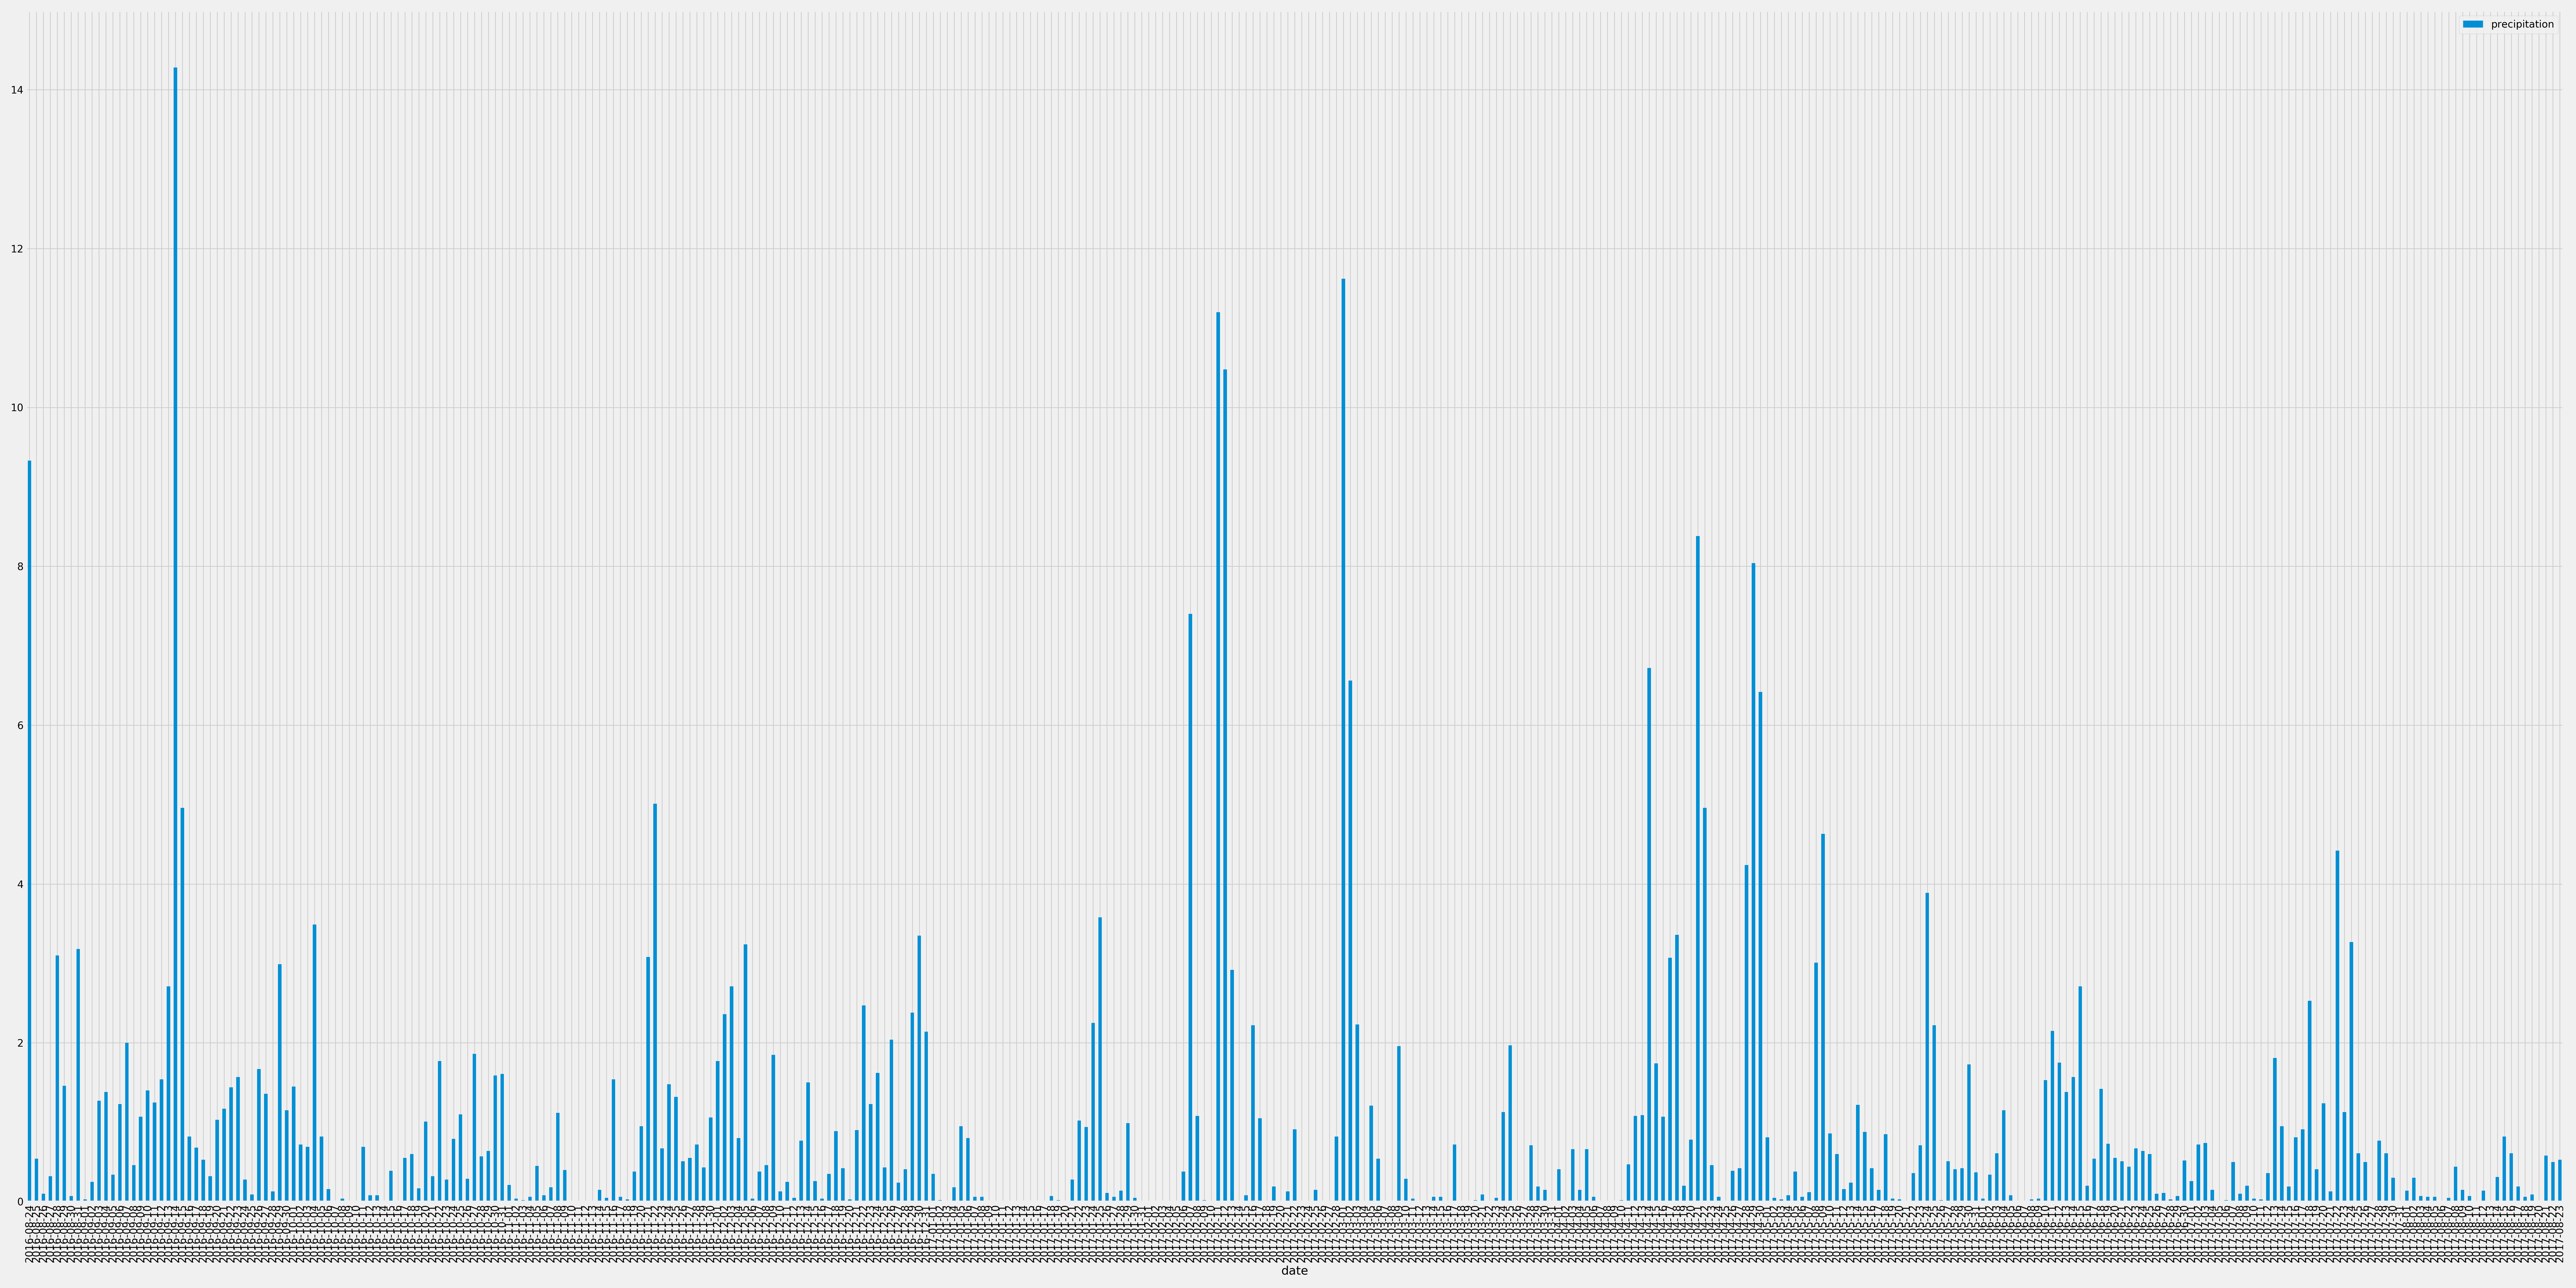

In [276]:
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
precipitation_df.plot.bar(figsize=(50,25), rot=90)
plt.tight_layout()
plt.show()

In [181]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [182]:
# How many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [185]:
# List the stations and their observation counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()
for station in station_counts:
    print(station)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [220]:
# Using the station id from the previous query, calculate the lowest, highest, and average temperature recorded from the most active station.
most_active = station_counts[0][0]
max_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
min_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
min_temp, max_temp, avg_temp


([(54.0)], [(85.0)], [(71.66378066378067)])

In [253]:
# Query the last 12 months of temperature observation data for the most active station
temp = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date > one_year_ago).all()

<IPython.core.display.Javascript object>


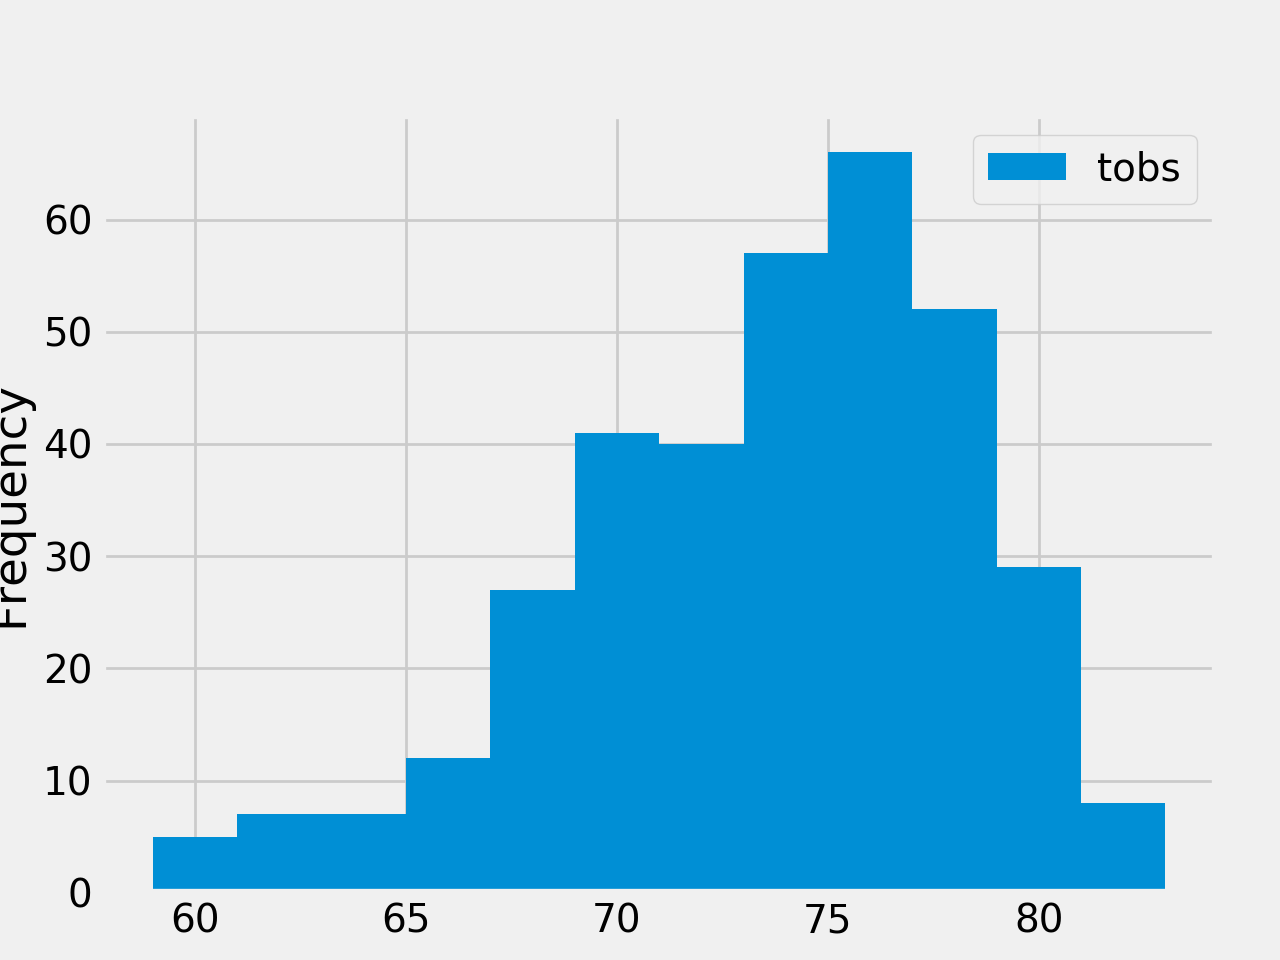

In [273]:
# Plot the results as a histogram
tobs = []
for row in temp:
    tobs.append(row[0])

plt.hist(tobs, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [305]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [331]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
start_date = dt.date(2018, 7, 26) - dt.timedelta(days=365)
end_date = dt.date(2018, 7, 29) - dt.timedelta(days=365)
trip = calc_temps(start_date, end_date)
tmin = [x[0] for x in trip][0]
tavg = [x[1] for x in trip][0]
tmax = [x[2] for x in trip][0]
tmin, tavg, tmax

(73.0, 78.96296296296296, 84.0)

<IPython.core.display.Javascript object>


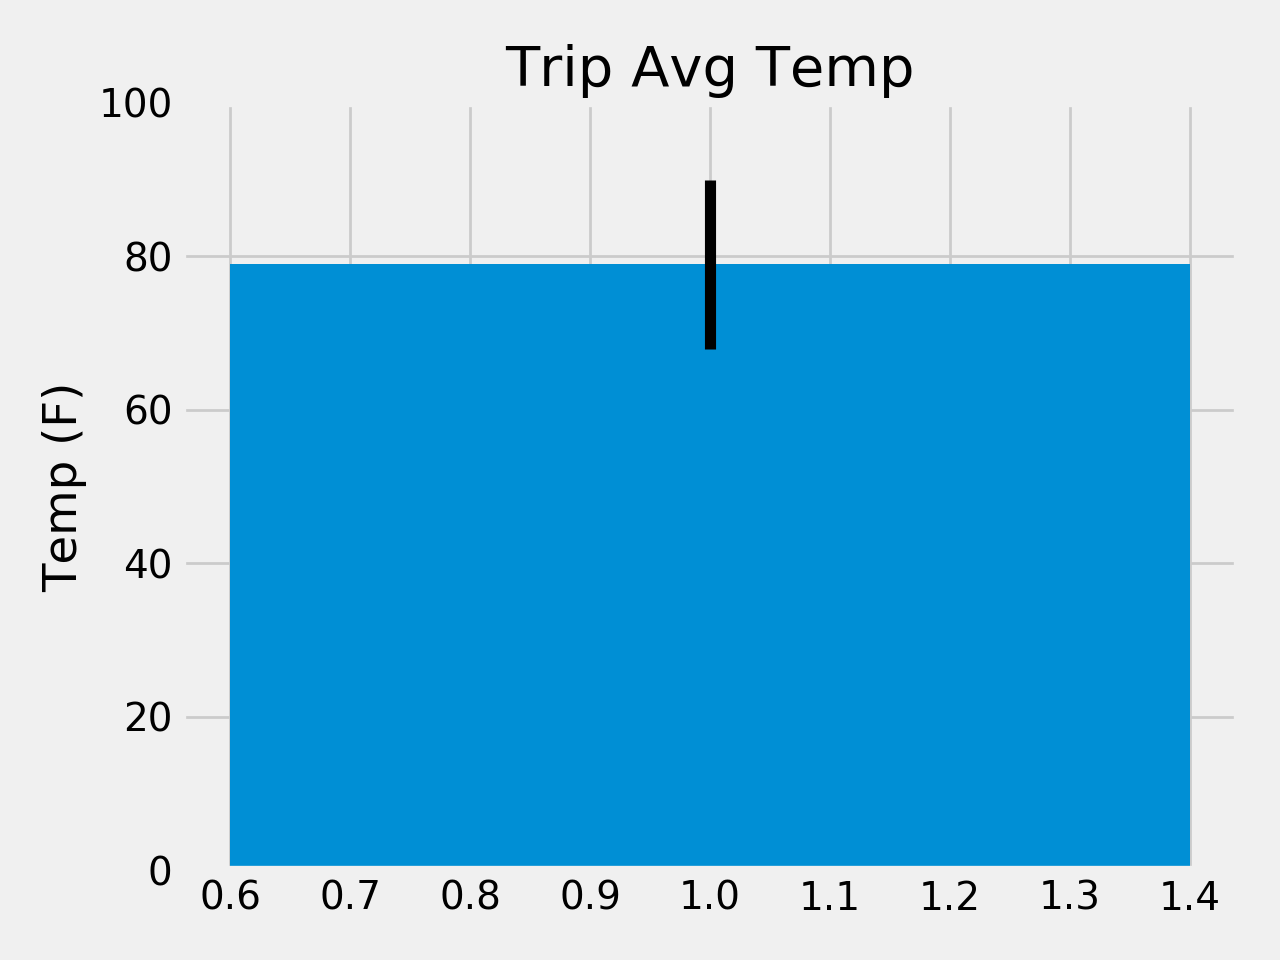

In [336]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1,height=tavg, yerr=(tmax-tmin))
plt.title("Trip Avg Temp")
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.show()

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


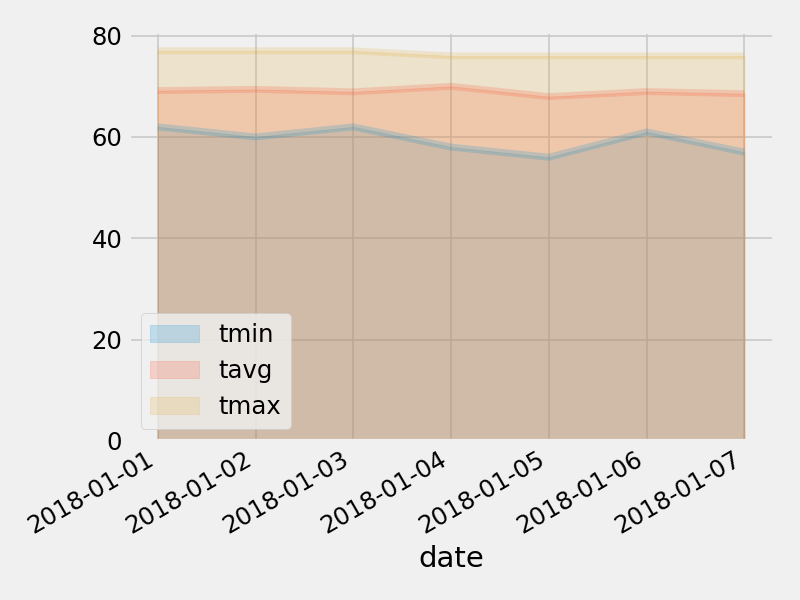

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
